## Compare JacobiKAN's ability in function interpolation with MLP

In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from JacobiKANLayer import JacobiKANLayer

In [26]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    return y

In [27]:
alpha_1 = 3
beta_1 = 3
alpha_2 = 3
beta_2 = 3
alpha_3 = 3
beta_3 = 3

# Define MLP and JacobiKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)


class JacobiKAN(nn.Module):
    def __init__(self):
        super(JacobiKAN, self).__init__()
        self.jacobikan1 = JacobiKANLayer(1, 10, 4, alpha_1, beta_1)
        self.jacobikan2 = JacobiKANLayer(10, 8, 3, alpha_2, beta_2)
        self.jacobikan3 = JacobiKANLayer(8, 1, 6, alpha_3, beta_3)

    def forward(self, x):
        x = self.jacobikan1(x)
        x = self.jacobikan2(x)
        x = self.jacobikan3(x)
        return x

Epoch 1/3000, JacobiKAN Loss: 12.6724, MLP Loss: 0.6549
Epoch 101/3000, JacobiKAN Loss: 0.2539, MLP Loss: 0.2198
Epoch 201/3000, JacobiKAN Loss: 0.0914, MLP Loss: 0.1942
Epoch 301/3000, JacobiKAN Loss: 0.0872, MLP Loss: 0.1868
Epoch 401/3000, JacobiKAN Loss: 0.0600, MLP Loss: 0.1845
Epoch 501/3000, JacobiKAN Loss: 0.0548, MLP Loss: 0.1829
Epoch 601/3000, JacobiKAN Loss: 0.0510, MLP Loss: 0.1815
Epoch 701/3000, JacobiKAN Loss: 0.0483, MLP Loss: 0.1797
Epoch 801/3000, JacobiKAN Loss: 0.0469, MLP Loss: 0.1771
Epoch 901/3000, JacobiKAN Loss: 0.0460, MLP Loss: 0.1745
Epoch 1001/3000, JacobiKAN Loss: 0.0551, MLP Loss: 0.1718
Epoch 1101/3000, JacobiKAN Loss: 0.0476, MLP Loss: 0.1722
Epoch 1201/3000, JacobiKAN Loss: 0.0539, MLP Loss: 0.1641
Epoch 1301/3000, JacobiKAN Loss: 0.1067, MLP Loss: 0.1667
Epoch 1401/3000, JacobiKAN Loss: 0.1359, MLP Loss: 0.1596
Epoch 1501/3000, JacobiKAN Loss: 0.2025, MLP Loss: 0.1587
Epoch 1601/3000, JacobiKAN Loss: 0.0491, MLP Loss: 0.2266
Epoch 1701/3000, JacobiKA

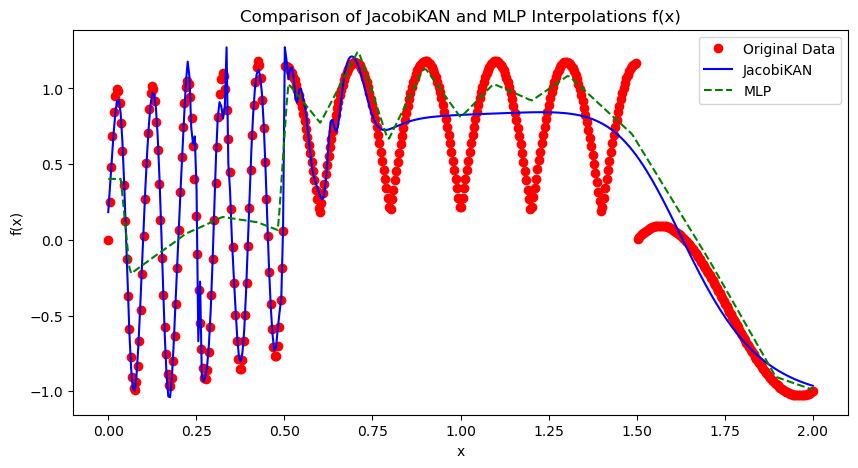

In [28]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
jacobi_model = JacobiKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_jacobi = torch.optim.Adam(jacobi_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.015)

# Train the models
epochs = 3000
for epoch in range(epochs):
    optimizer_jacobi.zero_grad()
    outputs_jacobi = jacobi_model(x_train)
    loss_jacobi = criterion(outputs_jacobi, y_train)
    loss_jacobi.backward()
    optimizer_jacobi.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, JacobiKAN Loss: {loss_jacobi.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_jacobi = jacobi_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_jacobi.numpy(), 'b-', label='JacobiKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of JacobiKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()